In [1]:
import os
from pathlib import Path
import random

import IPython

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import pickle
import torch

import librosa
import librosa.display
import soundfile as sf

os.chdir(r"C:\Users\Christopher\Documents\Uni\Fall21\DL_Sem\proj")

orig_wav_dir = "./data/orig/"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hq_sr = 44100
lq_sr = 11025

In [ ]:
# function to get resampled audios, mels from original filename
def get_data(filepath):
    # load original; resample to hq sampling rate
    hq_wav, _ = librosa.load(filepath, sr=hq_sr)
    
    # resample
    lq_wav = librosa.resample(hq_wav, hq_sr, lq_sr)
    
    # upsample again
    lq_wav_44100 = librosa.resample(lq_wav, lq_sr, hq_sr)

    # convert hq to mel
    sr = hq_sr
    n_fft=int(0.075 * sr)
    hop_length = int(0.25 * n_fft)
    hq_mel = librosa.feature.melspectrogram(hq_wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=512)

    # if too short (smaller than 128): pad with silence
    if hq_mel.shape[1] < 128:
        hq_mel = np.pad(hq_mel, [(0,0), (0,128-hq_mel.shape[1])])

    # also convert to dB scale
    hq_mel_db = librosa.power_to_db(hq_mel, ref=np.max)

    # convert lq to mel
    lq_mel = librosa.feature.melspectrogram(lq_wav_44100, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=512)

    # if too short (smaller than 128): pad with silence
    if lq_mel.shape[1] < 128:
        lq_mel = np.pad(lq_mel, [(0,0), (0,128-lq_mel.shape[1])])

    # also convert to dB scale
    lq_mel_db = librosa.power_to_db(lq_mel, ref=np.max)

    # make sure their dimensions match up (sometimes off by one...)
    hq_mel_db = hq_mel_db[:, :min(hq_mel_db.shape[1], lq_mel_db.shape[1])]
    lq_mel_db = lq_mel_db[:, :min(hq_mel_db.shape[1], lq_mel_db.shape[1])]
    
    # normalize mels to [0,1]
    
    hq_mel_db = hq_mel_db/80.0 + 1.0
    lq_mel_db = lq_mel_db/80.0 + 1.0
    
    return hq_wav, hq_mel_db, lq_wav, lq_mel_db

In [ ]:
# GENERATE MULTI SPEAKER DATA

# iterate over all directories in data dir, resample and generate spectrograms for both the resampled and original versions
# make list of training and test data files; randomly sample validation data from training data list


split_types = ["train", "val", "test"]

# make dirs
for split_type in split_types:
    Path("./data/" + split_type + "/wav/" + str(hq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
    Path("./data/" + split_type + "/mel/" + str(hq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
    Path("./data/" + split_type + "/wav/" + str(lq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
    Path("./data/" + split_type + "/mel/" + str(lq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
    

train_filenames = []
val_filenames = []
test_filenames = []

dataset_dir = r"C:\Users\Christopher\Documents\Uni\Fall21\DL_Sem\proj\DS 10283 3443\wav48_silence_trimmed"
    
# get training filenames
for dirname in os.listdir(dataset_dir)[:100]:
    orig_wav_dir = os.path.join(dataset_dir, dirname)
    for filename in os.listdir(orig_wav_dir):
        if filename.endswith(".flac") and "mic1" in filename:
            train_filenames.append(os.path.join(orig_wav_dir, filename))
        else:
            continue

# get test filenames
for dirname in os.listdir(dataset_dir)[100:]:
    orig_wav_dir = os.path.join(dataset_dir, dirname)
    for filename in os.listdir(orig_wav_dir):
        if filename.endswith(".flac") and "mic1" in filename:
            test_filenames.append(os.path.join(orig_wav_dir, filename))
        else:
            continue
        
# do random val/train split     
random.shuffle(train_filenames)
val_filenames = train_filenames[-100:]
train_filenames = train_filenames[:-100]
        
print("train files: " + str(len(train_filenames)))
print("val files: " + str(len(val_filenames)))
print("test files: " + str(len(test_filenames)))

split_lists = [train_filenames, val_filenames, test_filenames]

for i in range(3):
    for filename in split_lists[i]:
        hq_wav, hq_mel_db, lq_wav, lq_mel_db = get_data(filename)

        extr_filename = os.path.split(filename)[1][:-5]

        # save mel
        pickle.dump(hq_mel_db, open(os.path.join("./data/" + split_types[i] + "/mel/" + str(hq_sr) + "Hz", extr_filename + "_mel_db.pkl"), "wb"))
        pickle.dump(lq_mel_db, open(os.path.join("./data/" + split_types[i] + "/mel/" + str(lq_sr) + "Hz", extr_filename + "_mel_db.pkl"), "wb"))

        # save audio
        sf.write(os.path.join("./data/" + split_types[i] + "/wav/" + str(hq_sr) + "Hz", extr_filename + ".flac"), hq_wav, hq_sr)
        sf.write(os.path.join("./data/" + split_types[i] + "/wav/" + str(lq_sr) + "Hz", extr_filename + ".flac"), lq_wav, lq_sr)

train files: 5
val files: 0
test files: 0


In [16]:
# GENERATE KRÄHENBÜHL DATA

# iterate over all directories in data dir, resample and generate spectrograms for both the resampled and original versions
# make list of training and test data files; randomly sample validation data from training data list


# make dirs
Path("./data/kr/wav/" + str(hq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
Path("./data/kr/mel/" + str(hq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
Path("./data/kr/wav/" + str(lq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
Path("./data/kr/mel/" + str(lq_sr) + "Hz").mkdir(parents=True, exist_ok=True)
    

filenames = []

dataset_dir = r"C:\Users\Christopher\Documents\Uni\Fall21\DL_Sem\proj\kr_data"
    
# get filenames
for filename in os.listdir(dataset_dir):
    if filename.endswith(".flac"):
        filenames.append(os.path.join(dataset_dir, filename))
    else:
        continue
                
print("kr files: " + str(len(filenames)))

for filename in filenames:
    hq_wav, hq_mel_db, lq_wav, lq_mel_db = get_data(filename)

    extr_filename = os.path.split(filename)[1][:-5]

    # save mel
    pickle.dump(hq_mel_db, open(os.path.join("./data/kr/mel/" + str(hq_sr) + "Hz", extr_filename + "_mel_db.pkl"), "wb"))
    pickle.dump(lq_mel_db, open(os.path.join("./data/kr/mel/" + str(lq_sr) + "Hz", extr_filename + "_mel_db.pkl"), "wb"))

    # save audio
    sf.write(os.path.join("./data/kr/wav/" + str(hq_sr) + "Hz", extr_filename + ".flac"), hq_wav, hq_sr)
    sf.write(os.path.join("./data/kr/wav/" + str(lq_sr) + "Hz", extr_filename + ".flac"), lq_wav, lq_sr)

kr files: 8


sr: 44100
shape: (512, 316)
mel mean: 1.751689e-05


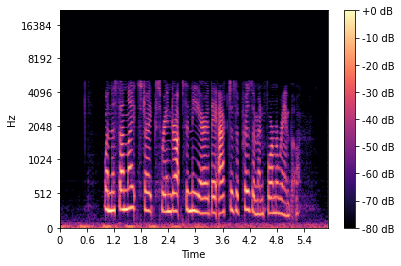

In [18]:
# test generating mels for different sampling rates

load_orig = False

dataset_dir = r"C:\Users\Christopher\Documents\Uni\Fall21\DL_Sem\proj\DS 10283 3443\wav48_silence_trimmed\p307"

sr = hq_sr

if load_orig:
    wav, _ = librosa.load(os.path.join(dataset_dir, "p307_006_mic1.flac"), sr=hq_sr)
else:
    wav, _ = librosa.load(os.path.join(dataset_dir, "p307_006_mic1.flac"), sr=lq_sr)
    wav = librosa.resample(wav, lq_sr, hq_sr)

n_mels = 512
n_fft = int(0.075 * sr)
hop_length = int(0.25 * n_fft)

print("sr: " + str(sr))

mel = librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

mel_db = librosa.power_to_db(mel, ref=np.max)

print("shape: " + str(mel_db.shape))
print("mel mean: " + str(np.median(mel)))

librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

In [66]:
# get audio back from mel - takes a long time (Griffin-Lim reconstruction); supposedly better quality by using neural net to estimate instead

inverse = librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=n_fft, hop_length=hop_length)
IPython.display.Audio(inverse, rate=sr)

In [28]:
# listen to validation data while training

viz_path = r"C:\Users\Christopher\Documents\Uni\Fall21\DL_Sem\proj\BasicSR\experiments\052_ESRGAN_x4_f64b23_DIV2K_400k_B16G1_051pretrain_wandb\visualization"
input_path = r"C:\Users\Christopher\Documents\Uni\Fall21\DL_Sem\proj\BasicSR\datasets\multispeaker\val\mel\11025Hz"

sr = 44100
n_fft=int(0.075 * sr)
hop_length = int(0.25 * n_fft)

filename = "p311_023_mic1_mel_db"
step = "80000"
viz_path = os.path.join(viz_path, filename)

pred_data = np.load(os.path.join(viz_path, filename + "_" + step + ".npz.npy")).squeeze()
input_data = pickle.load(open(os.path.join(input_path, filename + ".pkl"), "rb")).squeeze()
    
mel_data = pred_data

mel_data[:346, :min(input_data.shape[1], mel_data.shape[1])] = input_data[:346, :min(input_data.shape[1], mel_data.shape[1])]
    
mel_data = mel_data * 80.0 - 80.0 
    
mel = librosa.db_to_power(mel_data)

inverse = librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=n_fft, hop_length=hop_length)
IPython.display.Audio(inverse, rate=sr)